## Data Preprocessing

**Basic approaches in Data cleaning and preprocessing, materials based on:**

**Python Machine Learning by Sebastian Raschka and Vahid Mirjalili,
Second Edition, September 2017.**



*The quality of the data and the amount of useful information that it contains are key factors that determine how well a machine learning algorithm can learn. Therefore, it is absolutely critical that we make sure to examine and preprocess a dataset before we feed it to a learning algorithm. In this chapter, we will discuss the essential data preprocessing techniques that will help us build good machine learning models.*

The topics that we will cover here are as follows:

• Removing and imputing missing values from the dataset

• Getting categorical data into shape for machine learning algorithms

### Dealing with missing data

It is not uncommon in real-world applications for our samples to be missing one
or more values for various reasons. There could have been an error in the data
collection process, certain measurements are not applicable, or particular fields could
have been simply left blank in a survey, for example. We typically see missing values
as the blank spaces in our data table or as placeholder strings such as NaN, which
stands for not a number, or NULL (a commonly used indicator of unknown values in
relational databases).

Unfortunately, most computational tools are unable to handle such missing values,
or produce unpredictable results if we simply ignore them. Therefore, it is crucial
that we take care of those missing values before we proceed with further analyses.
In this section, we will work through several practical techniques for dealing with
missing values by removing entries from our dataset or imputing missing values
from other samples and features.

### Step 1. Identify missing values in tabular data

But before we discuss several techniques for dealing with missing values, let's create a simple example data frame from a Comma-separated Values (CSV) file to get a better grasp of the problem:

In [1]:
import pandas as pd
from io import StringIO
csv_data = \
 '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


Using the preceding code, we read CSV-formatted data into a pandas DataFrame
via the read_csv function and noticed that the two missing cells were replaced by
NaN. The StringIO function in the preceding code example was simply used for the
purposes of illustration. It allows us to read the string assigned to csv_data into a
pandas DataFrame as if it was a regular CSV file on our hard drive.
For a larger DataFrame, it can be tedious to look for missing values manually; in this
case, we can use the isnull method to return a DataFrame with Boolean values that
indicate whether a cell contains a numeric value (False) or if data is missing (True).
Using the sum method, we can then return the number of missing values per column
as follows:

In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

This way, we can count the number of missing values per column; in the following
subsections, we will take a look at different strategies for how to deal with this
missing data.

### Step 2. Eliminate samples or features with missing values

One of the easiest ways to deal with missing data is to simply remove the
corresponding features (columns) or samples (rows) from the dataset entirely; rows
with missing values can be easily dropped via the dropna method:

In [3]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


Similarly, we can drop columns that have at least one NaN in any row by setting the
axis argument to 1:

In [4]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


The dropna method supports several additional parameters that can come in handy:

In [5]:
# only drop rows where all columns are NaN
#(returns the whole array here since we don't have a row with where all values are NaN

df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [6]:
# drop rows that have less than 4 real values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
# only drop rows where NaN appear in specific columns (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


Although the removal of missing data seems to be a convenient approach, it also
comes with certain disadvantages; for example, we may end up removing too
many samples, which will make a reliable analysis impossible. Or, if we remove too
many feature columns, we will run the risk of losing valuable information that our
classifier needs to discriminate between classes. In the next section, we will thus
look at one of the most commonly used alternatives for dealing with missing values:
interpolation techniques.

### Step 3. Imputing missing values

Often, the removal of samples or dropping of entire feature columns is simply not feasible, because we might lose too much valuable data. In this case, we can use different interpolation techniques to estimate the missing values from the other training samples in our dataset. One of the most common interpolation techniques is mean imputation, where we simply replace the missing value with the mean value of the entire feature column. A convenient way to achieve this is by using the Imputer class from scikit-learn, as shown in the following code:

In [8]:
import numpy as np
lst_A = [1,5,5,10]
lst_B = [2,6,6,11]
lst_C = [3,np.nan,7,12]
lst_D = [4,8,8,np.nan]


df = pd.DataFrame({'A':lst_A,'B':lst_B,'C':lst_C,'D':lst_D})
df

,A,B,C,D
0,1,2,3.0,4.0
1,5,6,NaN,8.0
2,5,6,7.0,8.0
3,10,11,12.0,NaN


In [9]:


from sklearn.impute import SimpleImputer
#mean, median, most_frequent
imr = SimpleImputer(missing_values=np.nan, strategy='mean') #axis =1 if imputed variable is operated within column
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  7.33333333,  8.        ],
       [ 5.        ,  6.        ,  7.        ,  8.        ],
       [10.        , 11.        , 12.        ,  6.66666667]])

Here, we replaced each NaN value with the corresponding mean, which is separately
calculated for each feature column. If we changed the axis=0 setting to axis=1, we'd
calculate the row means. Other options for the strategy parameter are median or
most_frequent, where the latter replaces the missing values with the most frequent
values. This is useful for imputing categorical feature values, for example, a feature
column that stores an encoding of color names, such as red, green, and blue, and we
will encounter examples of such data later in this chapter. How about if data is mixed categorical and numerical?

### Notes
Time Series use Interpolation

In [10]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

data = [
    ['a', 1, 2],
    ['b', 1, 1],
    ['b', 2, 2],
    [np.nan, np.nan, np.nan]
]

X = pd.DataFrame(data)
xt = DataFrameImputer().fit_transform(X)

print('before...')
print(X)
print('after...')
print(xt)

before...
     0    1    2
0    a  1.0  2.0
1    b  1.0  1.0
2    b  2.0  2.0
3  NaN  NaN  NaN
after...
   0         1         2
0  a  1.000000  2.000000
1  b  1.000000  1.000000
2  b  2.000000  2.000000
3  b  1.333333  1.666667


### Step 4. Handling Categorical data


Most machine learning algorithms work with numerical values only. However, it is not uncommon that real-world datasets contain one or more categorical feature columns. In this section, we will make use of simple yet effective examples to see how we deal with this type of data in numerical computing libraries.

#### Nominal and ordinal features


When we are talking about categorical data, we have to further distinguish between
nominal and ordinal features. Ordinal features can be understood as categorical
values that can be sorted or ordered. For example, t-shirt size would be an ordinal
feature, because we can define an order XL > L > M. In contrast, nominal features
don't imply any order and, to continue with the previous example, we could think of
t-shirt color as a nominal feature since it typically doesn't make sense to say that, for
example, red is larger than blue.


#### Creating an example dataset

Before we explore different techniques to handle such categorical data, let's create a
new DataFrame to illustrate the problem:

In [11]:
import pandas as pd
df = pd.DataFrame([
['green', 'M', 10.1, 'class1'],
['red', 'L', 13.5, 'class2'],
['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


As we can see in the preceding output, the newly created DataFrame contains a
nominal feature (color), an ordinal feature (size), and a numerical feature (price)
column. The class labels (assuming that we created a dataset for a supervised
learning task) are stored in the last column. The learning algorithms for classification
that we discuss in this book do not use ordinal information in class labels.

### Step 4.1 Mapping ordinal features

To make sure that the learning algorithm interprets the ordinal features correctly,
we need to convert the categorical string values into integers. Unfortunately, there is
no convenient function that can automatically derive the correct order of the labels
of our size feature, so we have to define the mapping manually. In the following
simple example, let's assume that we know the numerical difference between
features, for example, XL = L +1 = M + 2:

In [12]:
size_mapping = {
'XL': 2,
'L': 1,
'M': 0}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,0,10.1,class1
1,red,1,13.5,class2
2,blue,2,15.3,class1


If we want to transform the integer values back to the original string representation
at a later stage, we can simply define a reverse-mapping dictionary inv_size_
mapping = {v: k for k, v in size_mapping.items()} that can then be
used via the pandas map method on the transformed feature column, similar to
the size_mapping dictionary that we used previously. We can use it as follows:

In [13]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### Step 4.2 Encoding class labels
Many machine learning libraries require that class labels are encoded as integer
values. Although most estimators for classification in scikit-learn convert class
labels to integers internally, it is considered good practice to provide class labels as
integer arrays to avoid technical glitches. To encode the class labels, we can use an
approach similar to the mapping of ordinal features discussed previously. We need
to remember that class labels are not ordinal, and it doesn't matter which integer
number we assign to a particular string label. Thus, we can simply enumerate the
class labels, starting at 0:

In [14]:
import numpy as np
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

Next, we can use the mapping dictionary to transform the class labels into integers:

In [15]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,0,10.1,0
1,red,1,13.5,1
2,blue,2,15.3,0


We can reverse the key-value pairs in the mapping dictionary as follows to map the
converted class labels back to the original string representation:

In [16]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,0,10.1,class1
1,red,1,13.5,class2
2,blue,2,15.3,class1


Alternatively, there is a convenient LabelEncoder class directly implemented in
scikit-learn to achieve this:

In [17]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

Note that the fit_transform method is just a shortcut for calling fit and
transform separately, and we can use the inverse_transform method to transform
the integer class labels back into their original string representation:

In [18]:
df

,color,size,price,classlabel
0,green,0,10.1,class1
1,red,1,13.5,class2
2,blue,2,15.3,class1


### Step 4.3 Performing one-hot encoding on nominal features

In the previous section, we used a simple dictionary-mapping approach to convert
the ordinal size feature into integers. Since scikit-learn's estimators for classification
treat class labels as categorical data that does not imply any order (nominal), we used
the convenient LabelEncoder to encode the string labels into integers. It may appear
that we could use a similar approach to transform the nominal color column of our
dataset, as follows:

In [44]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 0, 10.1],
       [2, 1, 13.5],
       [0, 2, 15.3]], dtype=object)

After executing the preceding code, the first column of the NumPy array X now
holds the new color values, which are encoded as follows:

• blue = 0

• green = 1

• red = 2

If we stop at this point and feed the array to our classifier, we will make one of the
most common mistakes in dealing with categorical data. Can you spot the problem?
Although the color values don't come in any particular order, a learning algorithm
will now assume that green is larger than blue, and red is larger than green.
Although this assumption is incorrect, the algorithm could still produce useful
results. However, those results would not be optimal.
A common workaround for this problem is to use a technique called one-hot
encoding. The idea behind this approach is to create a new dummy feature for each
unique value in the nominal feature column. Here, we would convert the color
feature into three new features: blue, green, and red. Binary values can then be
used to indicate the particular color of a sample; for example, a blue sample can be
encoded as blue=1, green=0, red=0. To perform this transformation, we can use the
OneHotEncoder that is implemented in the scikit-learn.preprocessing module:

In [45]:
X_color = X[0]

In [46]:
X_color.shape

(3,)

In [47]:
X_color = X_color.reshape(3,1)

In [52]:
X[:,0]

array([1, 2, 0], dtype=object)

In [55]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
X_new_color = ohe.fit_transform(X_color).toarray()

In [56]:
X_new_color

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [57]:
X = X[:,1:]
X

array([[0, 10.1],
       [1, 13.5],
       [2, 15.3]], dtype=object)

In [58]:
X = np.concatenate((X, X_new_color), axis=1)
X

array([[0, 10.1, 0.0, 1.0, 0.0],
       [1, 13.5, 1.0, 0.0, 0.0],
       [2, 15.3, 0.0, 0.0, 1.0]], dtype=object)

When we initialized the OneHotEncoder, we defined the column position of the
variable that we want to transform via the categorical_features parameter (note
that color is the first column in the feature matrix X). By default, the OneHotEncoder
returns a sparse matrix when we use the transform method, and we converted the
sparse matrix representation into a regular (dense) NumPy array for the purpose
of visualization via the toarray method. Sparse matrices are a more efficient way
of storing large datasets and one that is supported by many scikit-learn functions,
which is especially useful if an array contains a lot of zeros. To omit the toarray
step, we could alternatively initialize the encoder as OneHotEncoder(...,
sparse=False) to return a regular NumPy array.

An even more convenient way to create those dummy features via one-hot encoding
is to use the get_dummies method implemented in pandas. Applied to a DataFrame,
the get_dummies method will only convert string columns and leave all other
columns unchanged:

In [64]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,0,0,1,0
1,13.5,1,0,0,1
2,15.3,2,1,0,0


When we are using one-hot encoding datasets, we have to keep in mind that it
introduces multicollinearity, which can be an issue for certain methods (for instance,
methods that require matrix inversion). If features are highly correlated, matrices are
computationally difficult to invert, which can lead to numerically unstable estimates.
To reduce the correlation among variables, we can simply remove one feature
column from the one-hot encoded array. Note that we do not lose any important
information by removing a feature column, though; for example, if we remove the
column color_blue, the feature information is still preserved since if we observe
color_green=0 and color_red=0, it implies that the observation must be blue.

If we use the get_dummies function, we can drop the first column by passing a True
argument to the drop_first parameter, as shown in the following code example:

In [65]:
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)


,price,size,color_green,color_red
0,10.1,0,1,0
1,13.5,1,0,1
2,15.3,2,0,0


## Step 5. Bringing features onto the same scale

Feature scaling is a crucial step in our preprocessing pipeline that can easily be
forgotten. Decision trees and random forests are two of the very few machine
learning algorithms where we don't need to worry about feature scaling. Those
algorithms are scale invariant. However, the majority of machine learning and
optimization algorithms behave much better if features are on the same scale.

The importance of feature scaling can be illustrated by a simple example. Let's
assume that we have two features where one feature is measured on a scale from 1
to 10 and the second feature is measured on a scale from 1 to 100,000, respectively.
When we think of the squared error function in Adaline in Chapter 2, Training Simple
Machine Learning Algorithms for Classification, it is intuitive to say that the algorithm
will mostly be busy optimizing the weights according to the larger errors in the
second feature. Another example is the k-nearest neighbors (KNN) algorithm with
a Euclidean distance measure; the computed distances between samples will be
dominated by the second feature axis.


Now, there are two common approaches to bring different features onto the same
scale: normalization and standardization. Those terms are often used quite loosely
in different fields, and the meaning has to be derived from the context. Most often,
normalization refers to the rescaling of the features to a range of [0, 1], which is a
special case of min-max scaling. To normalize our data, we can simply apply the
min-max scaling to each feature column, where the new value (i)norm x of a sample x(i)
can be calculated as follows:

\begin{equation}
x^{(i)}_{norm} =\frac{x^{(i)} -x_{min}}{x_{max} -x_{min}}
\end{equation}

Here, $x^{(i)}$ is a particular sample, $x_{min}$ is the smallest value in a feature column, and
$x_{max}$ the largest value. The min-max scaling procedure is implemented in scikit-learn and can be used as
follows:

In [23]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

X_norm = mms.fit_transform(X)
print(X)
print(X_norm)

[[1 0 10.1]
 [2 1 13.5]
 [0 2 15.3]]
[[0.5        0.         0.        ]
 [1.         0.5        0.65384615]
 [0.         1.         1.        ]]


C:\Users\Yasser\Anaconda31\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Although normalization via min-max scaling is a commonly used technique that
is useful when we need values in a bounded interval, standardization can be more
practical for many machine learning algorithms, especially for optimization algorithms
such as gradient descent. The reason is that many linear models, such as the logistic
regression and SVM initialize the weights to 0 or small random values close
to 0. 

Using standardization, we center the feature columns at mean 0 with standard
deviation 1 so that the feature columns takes the form of a normal distribution, which
makes it easier to learn the weights. Furthermore, standardization maintains useful
information about outliers and makes the algorithm less sensitive to them in contrast
to min-max scaling, which scales the data to a limited range of values.
The procedure for standardization can be expressed by the following equation:

\begin{equation}
x^{(i)}_{std} = \frac{x^{(i)}-\mu_x}{\sigma_x}
\end{equation}


Here, $\mu_x$ is the sample mean of a particular feature column and $\sigma_x$ is the corresponding standard deviation.

The following  illustrates the difference between the two commonly used feature scaling techniques, standardization and normalization, on a simple sample dataset consisting of numbers 0 to 5:

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
stdsc = StandardScaler()
ex = np.array([[0, 1, 2, 3, 4, 5]])
ex.T
X_norm = mms.fit_transform(ex.T)
print("X_norm")
print(X_norm)
X_std=stdsc.fit_transform(ex.T)
print("\nX_std")
print(X_std)



X_norm
[[0. ]
 [0.2]
 [0.4]
 [0.6]
 [0.8]
 [1. ]]

X_std
[[-1.46385011]
 [-0.87831007]
 [-0.29277002]
 [ 0.29277002]
 [ 0.87831007]
 [ 1.46385011]]


C:\Users\Yasser\Anaconda31\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Yasser\Anaconda31\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Note that it important to highlight that we fit the StandardScaler or the MinmaxScaler class only once—on the training data—and use those parameters to transform the test set or any new data point.

>>> X_train_std = stdsc.fit_transform(X_train)

>>> X_test_std = stdsc.transform(X_test)

## SUMMARY

In summary, the following are the basic steps in data preprocessing/cleaning. A more tedious job includes purging categorical variables that are one and the same like: "Apple, aple, mansanas, appl" all into apple; such can be handled by encoding class labels but that is generally more tedious.

Step 1. Identify missing values in tabular data

Step 2. Eliminate samples or features with missing values OR

Step 3. Imputing missing values

Step 4. Handling Categorical data 

    4.1 Mapping ordinal features
    
    4.2 Encoding class labels
    
    4.3 Performing one-hot encoding on nominal features

Step 5. Bringing features onto the same scale

## Example 6. Bank Marketing

Data Set Information:
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the client will subscribe (yes/no) a term deposit (variable y).


Bank Marketing Data Set

Source: [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014



In [25]:
import pandas as pd
df = pd.read_excel('bank_dirty_500.xlsx', sheet_name="Sheet1")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,59,self-employed,married,university.degree,no,yes,no,cellular,may,tue,...,1.0,999.0,1.0,failure,-1.8,92.893,-46.2,1.266,5099.1,no
1,31,services,single,high.school,no,no,yes,cellular,jul,thu,...,17.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
2,31,admin.,married,professional.course,no,no,yes,cellular,dec,mon,...,2.0,999.0,1.0,failure,-3.0,92.713,-33.0,0.709,5023.5,yes
3,34,admin.,married,high.school,no,yes,yes,telephone,may,fri,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
4,37,admin.,married,high.school,unknown,yes,no,cellular,jul,mon,...,3.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


In [26]:
df.isnull().sum()

age                0
job                1
marital            3
education          7
default            5
housing            9
loan               7
contact           15
month             10
day_of_week        6
duration           8
campaign           4
pdays              5
previous           4
poutcome           5
emp.var.rate       4
cons.price.idx     6
cons.conf.idx      1
euribor3m          1
nr.employed        0
y                  0
dtype: int64

In [27]:
df_cat = df[['job','marital','poutcome']]

In [28]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

data = [
    ['a', 1, 2],
    ['b', 1, 1],
    ['b', 2, 2],
    [np.nan, np.nan, np.nan]
]

# X = pd.DataFrame(data)
# xt = DataFrameImputer().fit_transform(X)

# print('before...')
# print(X)
# print('after...')
# print(xt)

In [29]:
df_X = pd.DataFrame(df_cat)
df_xt = DataFrameImputer().fit_transform(df_X)

In [30]:
df[['job','marital','poutcome']] = df_xt[['job','marital','poutcome']]

In [31]:
df.isnull().sum()

age                0
job                0
marital            0
education          7
default            5
housing            9
loan               7
contact           15
month             10
day_of_week        6
duration           8
campaign           4
pdays              5
previous           4
poutcome           0
emp.var.rate       4
cons.price.idx     6
cons.conf.idx      1
euribor3m          1
nr.employed        0
y                  0
dtype: int64

In [32]:
import numpy as np
df['education'].replace('unknown', -1, inplace = True)
df['education'].replace('basic.4y', 0, inplace = True)
df['education'].replace('basic.6y', 1, inplace = True)
df['education'].replace('basic.9y', 2, inplace = True)
df['education'].replace('high.school', 3, inplace = True)
df['education'].replace('university.degree', 4, inplace = True)
df['education'].replace('professional.course', 5, inplace = True)
df['education'].hist(figsize=(4,4), bins=6) 

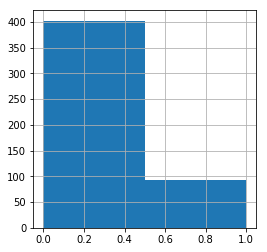

In [33]:
import numpy as np
df_def = df['default'].loc[df['default'].notnull()]
def_mapping = {label:idx for idx,label in enumerate(np.unique(df_def))}
df_def = df_def.map(def_mapping)
#df_def.hist(figsize=(4,4), bins=30) 
df['default'] = df_def
df['default'].hist(figsize=(4,4), bins=2) 

In [34]:
df_hl= df[['housing','loan']]
df_hl.replace('yes', 1, inplace = True)
df_hl.replace('no', -1, inplace = True)
df_hl.replace('unknown', 0, inplace = True)
# df['housing','loan'].replace('yes', 1, inplace = True)
df['housing'] = df_hl['housing']
df['loan'] = df_hl['loan']

C:\Users\Yasser\Anaconda31\lib\site-packages\pandas\core\frame.py:3795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


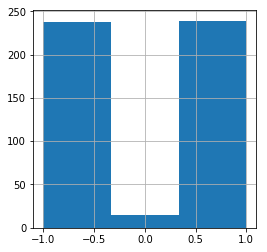

In [35]:
df['housing'].hist(figsize=(4,4), bins=3) 

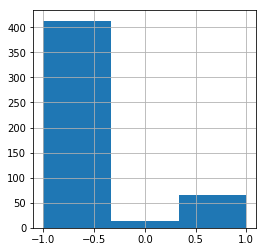

In [36]:
df['loan'].hist(figsize=(4,4), bins=3) 

In [37]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

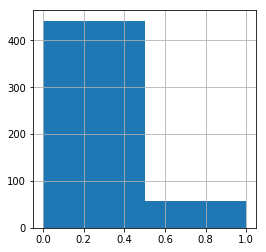

In [38]:
df_y = df['y']
y_mapping = {label:idx for idx,label in enumerate(np.unique(df_y))}
df_y = df_y.map(y_mapping)
#df_def.hist(figsize=(4,4), bins=30) 
df['y'] = df_y
df['y'].hist(figsize=(4,4), bins=2) 

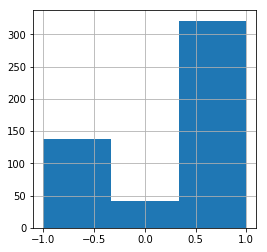

In [39]:
df['marital'].replace('married', 1, inplace = True)
df['marital'].replace('single', -1, inplace = True)
df['marital'].replace('divorced', 0, inplace = True)
df['marital'].hist(figsize=(4,4), bins=3)

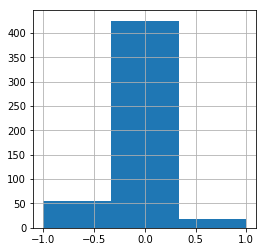

In [40]:
df['poutcome'].replace('success', 1, inplace = True)
df['poutcome'].replace('failure', -1, inplace = True)
df['poutcome'].replace('nonexistent', 0, inplace = True)
df['poutcome'].hist(figsize=(4,4), bins=3)

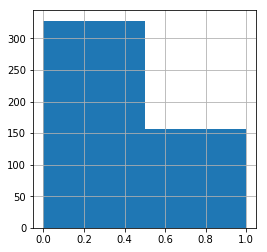

In [41]:
import numpy as np
df_con = df['contact'].loc[df['contact'].notnull()]
con_mapping = {label:idx for idx,label in enumerate(np.unique(df_con))}
df_con = df_con.map(con_mapping)
#df_def.hist(figsize=(4,4), bins=30) 
df['contact'] = df_con
df['contact'].hist(figsize=(4,4), bins=2) 

In [42]:
df.isnull().sum()

age                0
job                0
marital            0
education          7
default            5
housing            9
loan               7
contact           15
month             10
day_of_week        6
duration           8
campaign           4
pdays              5
previous           4
poutcome           0
emp.var.rate       4
cons.price.idx     6
cons.conf.idx      1
euribor3m          1
nr.employed        0
y                  0
dtype: int64

In [49]:
df_woj =  df.drop(df.columns[[1,8,9]], axis = 1)

In [56]:
df_wnull= df_woj[df_woj.isnull().any(axis=1)]
df_wnull.head()

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
9,24,-1,NaN,0.0,1.0,-1.0,1.0,112.0,4.0,999.0,0.0,0,1.1,93.994,-36.4,4.857,5191.0,0
10,37,0,2.0,0.0,NaN,-1.0,0.0,122.0,1.0,999.0,0.0,0,1.4,93.918,-42.7,4.957,5228.1,0
17,32,1,3.0,0.0,NaN,1.0,1.0,140.0,NaN,999.0,0.0,0,1.4,94.465,-41.8,4.960,5228.1,0
19,48,0,0.0,0.0,-1.0,-1.0,0.0,134.0,1.0,NaN,0.0,0,-0.1,93.200,-42.0,4.120,5195.8,0
21,36,-1,5.0,0.0,-1.0,-1.0,0.0,275.0,1.0,999.0,0.0,0,1.4,NaN,-36.1,4.967,5228.1,0


In [57]:
array_index = np.array(df_wnull.index)
df_wonull = df_woj.drop(df_woj.index[array_index])
df_wonull.head()

,age,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,59,1,4.0,0.0,1.0,-1.0,0.0,61.0,1.0,999.0,1.0,-1,-1.8,92.893,-46.2,1.266,5099.1,0
1,31,-1,3.0,0.0,-1.0,1.0,0.0,9.0,17.0,999.0,0.0,0,1.4,93.918,-42.7,4.968,5228.1,0
2,31,1,5.0,0.0,-1.0,1.0,0.0,367.0,2.0,999.0,1.0,-1,-3.0,92.713,-33.0,0.709,5023.5,1
3,34,1,3.0,0.0,1.0,1.0,1.0,20.0,1.0,999.0,0.0,0,1.1,93.994,-36.4,4.855,5191.0,0
4,37,1,3.0,1.0,1.0,-1.0,0.0,204.0,3.0,999.0,0.0,0,1.4,93.918,-42.7,4.962,5228.1,0


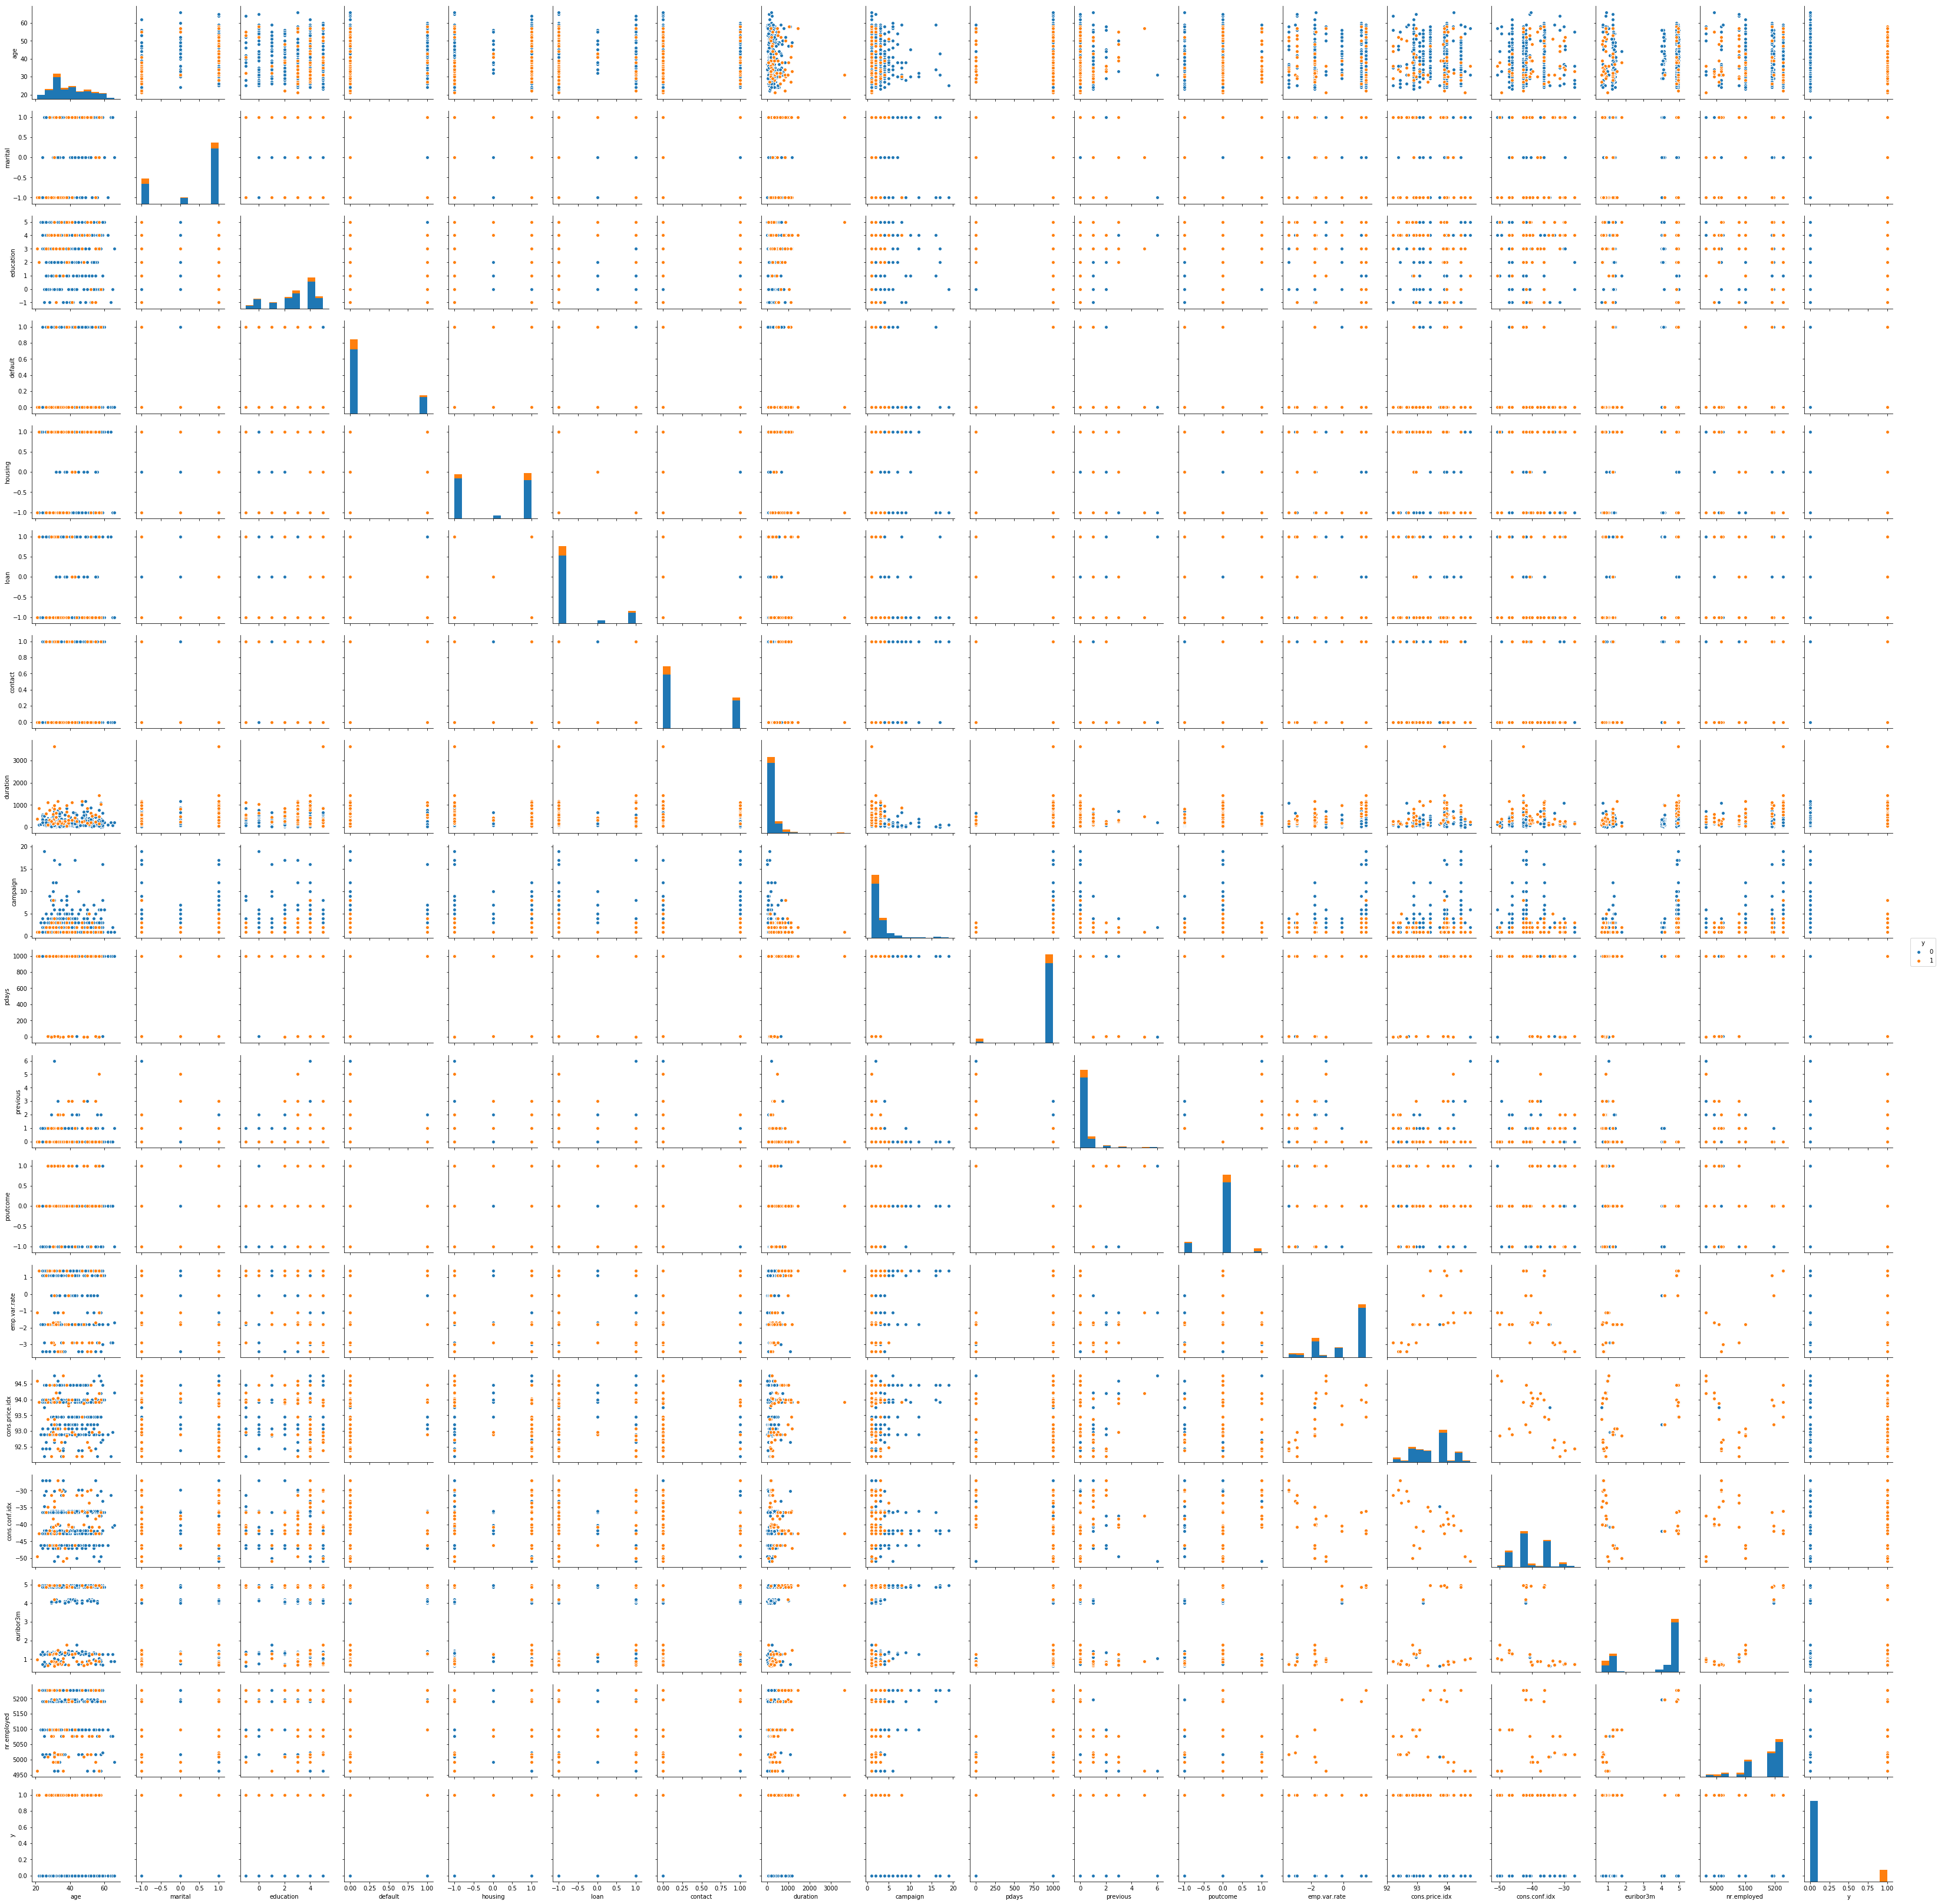

In [67]:
import seaborn as sns
sns.pairplot(df_wonull, hue="y");

In [61]:
import scipy.stats as s
s_list = []
for i in range(0,18):
    for u in range (0,18):
        if (u != i):
            cr,p = s.pearsonr(df_wonull.iloc[:,i], df_wonull.iloc[:,u])
            print(df_wonull.columns[i], " and ", df_wonull.columns[u],":", cr)

age  and  marital : 0.3843894472788228
age  and  education : -0.16387772305642256
age  and  default : 0.18232348584628816
age  and  housing : 0.07376936808244457
age  and  loan : 0.006728057886033231
age  and  contact : 0.012747660112313118
age  and  duration : 0.008903174536549754
age  and  campaign : -0.03911124172602707
age  and  pdays : -0.01664936473881983
age  and  previous : 0.043445198583749296
age  and  poutcome : 0.009279389601919819
age  and  emp.var.rate : -0.014314499006707481
age  and  cons.price.idx : 0.017173475798776025
age  and  cons.conf.idx : 0.041560032793458386
age  and  euribor3m : -0.004983009705903128
age  and  nr.employed : -0.034234058719430756
age  and  y : -0.02639025419607229
marital  and  age : 0.3843894472788228
marital  and  education : -0.12115252943093228
marital  and  default : 0.11888982032083731
marital  and  housing : 0.019749928017745968
marital  and  loan : -0.027639931986564607
marital  and  contact : 0.10109744314110143
marital  and  duration 

poutcome  and  emp.var.rate : 0.13771677558860193
poutcome  and  cons.price.idx : 0.13382502408267702
poutcome  and  cons.conf.idx : 0.21266258283958211
poutcome  and  euribor3m : 0.13237652927953042
poutcome  and  nr.employed : 0.08993126402192768
poutcome  and  y : 0.19321015601926295
emp.var.rate  and  age : -0.014314499006707481
emp.var.rate  and  marital : 0.05522929192653647
emp.var.rate  and  education : -0.055586638974963985
emp.var.rate  and  default : 0.1497466332126379
emp.var.rate  and  housing : -0.0625779689365205
emp.var.rate  and  loan : -0.08493525999621399
emp.var.rate  and  contact : 0.37226691507036647
emp.var.rate  and  duration : 0.06640612769640396
emp.var.rate  and  campaign : 0.1623277029148717
emp.var.rate  and  pdays : 0.33721856227714175
emp.var.rate  and  previous : -0.4240493302368806
emp.var.rate  and  poutcome : 0.13771677558860193
emp.var.rate  and  cons.price.idx : 0.7719999676835294
emp.var.rate  and  cons.conf.idx : 0.06455968324890245
emp.var.rate  

In [163]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

Number_trials=50

def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

        neighbors_settings = range(1,70)
        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:   
            clf = KNeighborsClassifier(n_neighbors=n_neighbors) # build the model 
            clf.fit(X_train, y_train)    
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)   
        
    score = np.mean(score_test, axis=0)
    #return n_neighbor, accuracy
    return ['kNN', np.amax(score), 'N_Neighbor = {0}'.format(np.argmax(score)+1), 'NA']

def train_logistic(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    #C = [0.01]

    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            lr = LogisticRegression(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            if alpha_run == 0.01:
                coefs=lr.coef_ 
                weighted_coefs.append(coefs) #append all the computed coefficients per trial
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    
    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials 
    #print(mean_coefs) 
    score = np.mean(score_test, axis=0)
    #return score.shape
    #coefs = lr.coef_
    #return C value, accuracy, column/feature name
    
    if scaler == 'ON':
        top_predictor = 'DEBUGGING'
  #  if scaler == 'OFF':
    #    top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
            
    return ['Logistic ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor]

def train_svm(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
    #C = [0.01]
    
    score_train = []
    score_test = []
    weighted_coefs=[]
    
    for seed in range(Number_trials):
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            if alpha_run == 0.01:
                coefs = svc.coef_
                weighted_coefs.append(coefs)
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
 

    mean_coefs=np.mean(weighted_coefs, axis=0) #get the mean of the weighted coefficients over all the trials       
    score = np.mean(score_test, axis=0)
    
    if scaler == 'ON':
        top_predictor = 'DEBUGGING'
   # if scaler == 'OFF':
        #top_predictor=X.columns[np.argmax(np.abs(mean_coefs))]
    #return score
    #return C value, accuracy, column/feature name
    return ['Linear SVM ({0})'.format(reg), np.amax(score), \
            'C = {0}'.format(C[np.argmax(score)]), top_predictor]

In [168]:
scaler='ON'
X = df_wonull.drop('loan', axis=1)
y = df_wonull['loan']

a = train_knn(X,y)
b = train_logistic(X,y,reg='l2')
c = train_logistic(X,y,reg='l1')
d = train_svm(X,y,reg='l2')
e = train_svm(X,y,reg='l1')
print(a)
print(b)
print(c)
print(d)
print(e)

['kNN', 0.8324770642201839, 'N_Neighbor = 9', 'NA']
['Logistic (l2)', 0.8324770642201836, 'C = 1e-08', 'DEBUGGING']
['Logistic (l1)', 0.8324770642201836, 'C = 1e-08', 'DEBUGGING']
['Linear SVM (l2)', 0.8324770642201836, 'C = 1e-08', 'DEBUGGING']
['Linear SVM (l1)', 0.8324770642201836, 'C = 1e-08', 'DEBUGGING']


In [144]:
df.isnull().sum()

age                0
job                0
marital            0
education          7
default            5
housing            9
loan               7
contact           15
month             10
day_of_week        6
duration           8
campaign           4
pdays              5
previous           4
poutcome           0
emp.var.rate       4
cons.price.idx     6
cons.conf.idx      1
euribor3m          1
nr.employed        0
y                  0
dtype: int64

In [151]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [152]:
df_X = pd.DataFrame(df['default'])
df_xt = DataFrameImputer().fit_transform(df_X)

In [154]:
df['default']=df_xt

In [155]:
df.isnull().sum()

age                0
job                0
marital            0
education          7
default            0
housing            9
loan               7
contact           15
month             10
day_of_week        6
duration           8
campaign           4
pdays              5
previous           4
poutcome           0
emp.var.rate       4
cons.price.idx     6
cons.conf.idx      1
euribor3m          1
nr.employed        0
y                  0
dtype: int64

In [ ]:
class DataFrameImputer2(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
